# Comparación de modelos

## Configuración

### Librerías y funciones

In [1]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D, Dropout, Conv2D, Resizing, RandomZoom, RandomHeight, RandomWidth
from keras.regularizers import L2
from keras.applications import EfficientNetB0, ResNet50V2, InceptionV3, MobileNet
from keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-06-02 13:08:35.776749: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-02 13:08:35.912723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 13:08:36.640122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Configuración del GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-06-02 13:08:37.621267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:37.690204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:37.690233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carga y procesamiento de datos

### Definiciones del dataset

In [4]:
data_dir = 'data_model'
resolution=(256, 455)
num_classes=len(os.listdir(data_dir))

### Carga de datos

In [5]:
data = tf.keras.utils.image_dataset_from_directory(directory=data_dir,
                                                   label_mode='categorical',
                                                   image_size=resolution,
                                                   seed=1)

Found 9213 files belonging to 72 classes.


2023-06-02 13:08:38.370104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:38.370150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:38.370161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:39.085831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-02 13:08:39.085874: I tensorflow/compile

### Escalamiento

In [6]:
data = data.map(lambda x,y:(x/255, y))

### Split

In [7]:
train_size=int(len(data)*0.7)+1
dev_size=int(len(data)*0.15)
test_size=int(len(data)*0.15)

In [8]:
if train_size+dev_size+test_size==len(data):
    print('Split correcto')
else:
    print('Split incorrecto')

Split correcto


In [9]:
train = data.take(train_size)
dev = data.skip(train_size).take(dev_size)
test = data.skip(train_size+dev_size).map(lambda x,y: (tf.image.resize(x, size=(224, 224)), y)).take(test_size)

## Modelos

### Aumento de datos

In [10]:
data_augment=Sequential([
    RandomZoom(0.1),
    RandomHeight(0.1),
    RandomWidth(0.1)
])

### Ejemplo

In [11]:
example_folder=os.listdir(data_dir)[np.random.randint(0,num_classes)]
example_file=os.path.join(data_dir, example_folder, os.listdir(os.path.join(data_dir, example_folder))[np.random.randint(len(os.listdir(os.path.join(data_dir, example_folder))))])
example_file

'data_model/About_confirm/93_72_4218_39_32.png'

(480, 1146, 3)

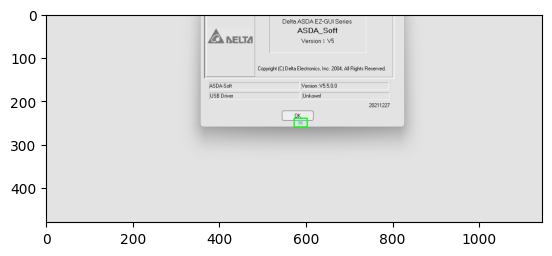

In [12]:
example=plt.imread(example_file)
plt.imshow(example)
example.shape

(507, 1122, 3)

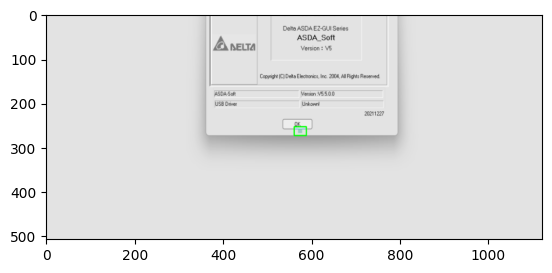

In [13]:
out=data_augment(np.expand_dims(example, axis=0))
plt.imshow(np.squeeze(out))
np.squeeze(out).shape

### Función para la creación de modelos

In [14]:
def create_model(model, type='transfer_learning', layers_num=None, dropout_rate=0.3):

    base_model=model(include_top=False)

    if type=='transfer_learning':
        base_model.trainable=False
    elif type=='fine_tuning':
        base_model.trainable=True
        for layer in base_model.layers[:-layers_num]:
            layer.trainable=False
    else:
        return None
    
    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    x=base_model(x)
    x=Dropout(dropout_rate)(x)
    x=GlobalAveragePooling2D()(x)
    outputs=Dense(num_classes, activation='softmax')(x)
    out_model=Model(inputs, outputs)

    return out_model

### Callbacks

In [15]:
#  Parar el modelo tras 5 épocas sin mejora en la 'validation loss'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
# Reducir la tasa de aprendizaje tras 10 épocas para un ajuste más fino
def scheduler(epoch, lr):
    if epoch<=10:
        return lr
    else:
        return lr*np.exp(-0.9)

lr_scheduler=LearningRateScheduler(scheduler)

In [17]:
tb_callback=TensorBoard(log_dir='Experimentos')

### Modelo empírico CNN

In [18]:
def final_model(ks, units, activation, lr, lmbda, prob):
    inputs=Input(shape=resolution+(3,))
    x=data_augment(inputs, training=True)
    x=Resizing(224, 224)(x)

    x=Conv2D(16, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(32, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(64, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Conv2D(128, ks, 1, padding='same', activation=activation, kernel_regularizer=L2(lmbda))(x)
    x=MaxPooling2D()(x)
    x=Dropout(prob)(x)

    x=Flatten()(x)

    x=Dense(units, activation=activation)(x)

    outputs=Dense(num_classes, activation='softmax')(x)
    x=Dropout(prob)(x)

    model=Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))

    return model

In [19]:
Modelo_empirico=final_model(3, 512, 'leaky_relu', 0.001, 0.0001, 0.01)
Modelo_empirico.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                             

In [20]:
history_modelo_empirico=Modelo_empirico.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback])

Epoch 1/100


2023-06-02 13:08:40.043042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-06-02 13:08:40.043223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]
2023-06-02 13:08:40.375265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-02 13:08:41.748224: I tensorflow/compiler/xl

201/202 [============================>.] - ETA: 0s - loss: 2.5693 - accuracy: 0.3730

2023-06-02 13:08:49.768587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9213]
	 [[{{node Placeholder/_0}}]]
2023-06-02 13:08:49.768771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]


202/202 [==============================] - 13s 45ms/step - loss: 2.5596 - accuracy: 0.3755 - val_loss: 0.9482 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - 9s 46ms/step - loss: 0.6796 - accuracy: 0.7851 - val_loss: 0.5539 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - 10s 47ms/step - loss: 0.4188 - accuracy: 0.8642 - val_loss: 0.5068 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - 10s 48ms/step - loss: 0.3308 - accuracy: 0.8950 - val_loss: 0.3734 - val_accuracy: 0.8881 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - 10s 47ms/step - loss: 0.2761 - accuracy: 0.9104 - val_loss: 0.3461 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - 10s 47ms/step - loss: 0.2257 - accuracy: 0.9268 - val_loss: 0.2925 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - 10s 47ms/s

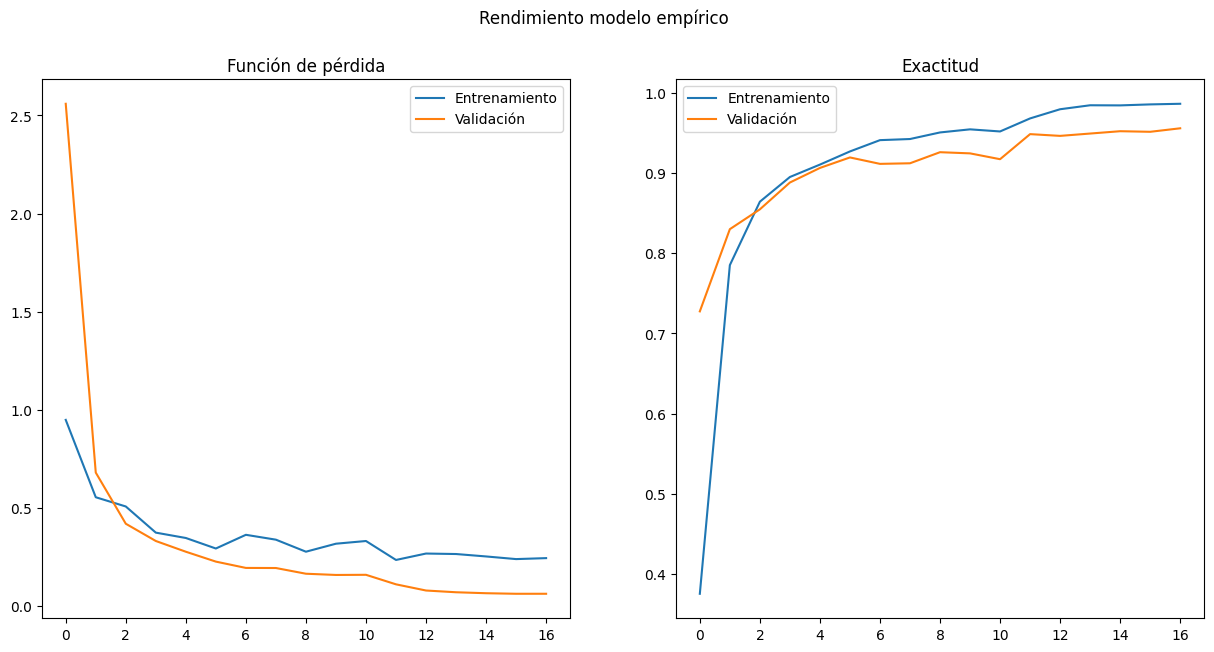

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_modelo_empirico.history['val_loss'], label='Entrenamiento')
ax1.plot(history_modelo_empirico.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_modelo_empirico.history['accuracy'], label='Entrenamiento')
ax2.plot(history_modelo_empirico.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento modelo empírico');

### EfficientNET

#### Número de capas

In [190]:
print(f'{len(EfficientNetB0(include_top=False).layers)} layers')

238 layers


In [191]:
EfficientNET_FT=create_model(EfficientNetB0, type='fine_tuning', layers_num=150)
EfficientNET_FT.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential_24 (Sequential)  (None, None, None, 3)     0         
                                                                 
 resizing_21 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 dropout_41 (Dropout)        (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_16  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [192]:
EfficientNET_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_EfficientNET_FT=EfficientNET_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback])

Epoch 1/100


2023-06-01 13:15:58.197063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 17s 69ms/step - loss: 2.2461 - accuracy: 0.3916 - val_loss: 4.3612 - val_accuracy: 0.0174 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - 13s 65ms/step - loss: 1.3500 - accuracy: 0.5934 - val_loss: 4.0251 - val_accuracy: 0.1439 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - 13s 65ms/step - loss: 1.0150 - accuracy: 0.6832 - val_loss: 4.4977 - val_accuracy: 0.0821 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - 13s 65ms/step - loss: 0.8195 - accuracy: 0.7321 - val_loss: 1.7156 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - 13s 65ms/step - loss: 0.6857 - accuracy: 0.7791 - val_loss: 2.4914 - val_accuracy: 0.3379 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - 13s 65ms/step - loss: 0.5539 - accuracy: 0.8181 - val_loss: 0.7077 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - 13s 65ms/

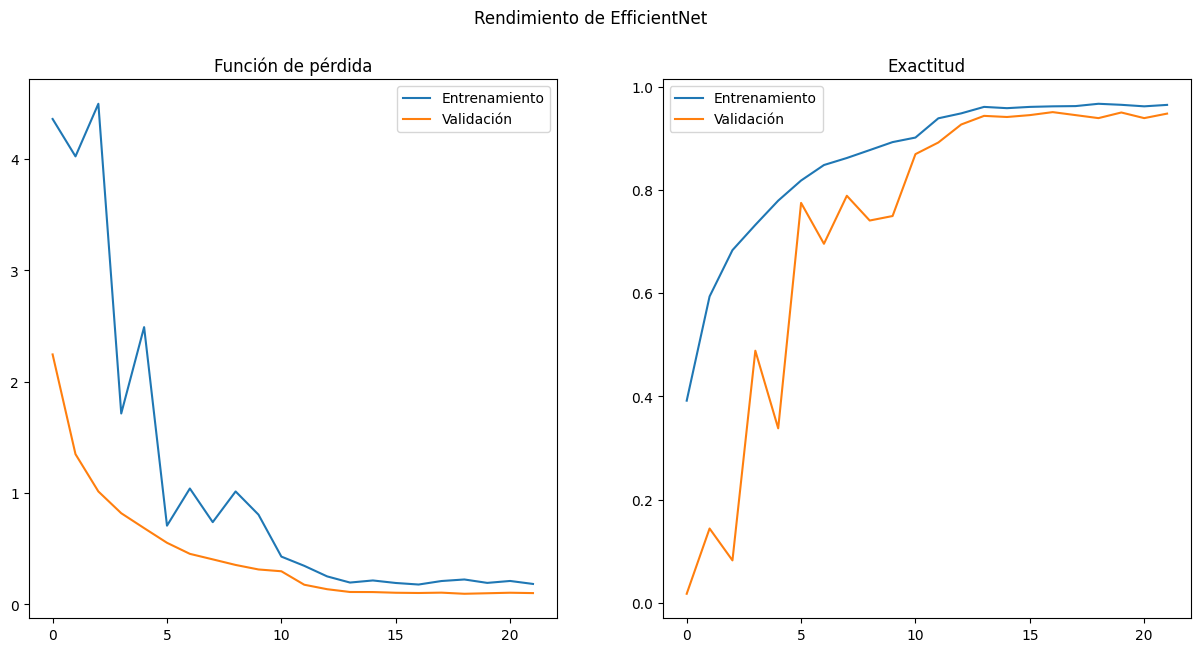

In [193]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_EfficientNET_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_EfficientNET_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_EfficientNET_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_EfficientNET_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento de EfficientNet');

## ResNET

### Número de capas

In [194]:
print(f'{len(ResNet50V2(include_top=False).layers)} layers')

190 layers


In [195]:
ResNET_FT=create_model(ResNet50V2, type='fine_tuning', layers_num=80)
ResNET_FT.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential_24 (Sequential)  (None, None, None, 3)     0         
                                                                 
 resizing_22 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 dropout_42 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [196]:
ResNET_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_ResNET_FT=ResNET_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback])

Epoch 1/100


2023-06-01 13:20:53.628334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 17s 74ms/step - loss: 1.3223 - accuracy: 0.6722 - val_loss: 0.4545 - val_accuracy: 0.8474 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 14s 71ms/step - loss: 0.3472 - accuracy: 0.8872 - val_loss: 0.2885 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 14s 71ms/step - loss: 0.2102 - accuracy: 0.9299 - val_loss: 0.3137 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 14s 70ms/step - loss: 0.1878 - accuracy: 0.9421 - val_loss: 0.1998 - val_accuracy: 0.9404 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 14s 71ms/step - loss: 0.1457 - accuracy: 0.9531 - val_loss: 0.2054 - val_accuracy: 0.9477 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 14s 70ms/step - loss: 0.1368 - accuracy: 0.9571 - val_loss: 0.1698 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

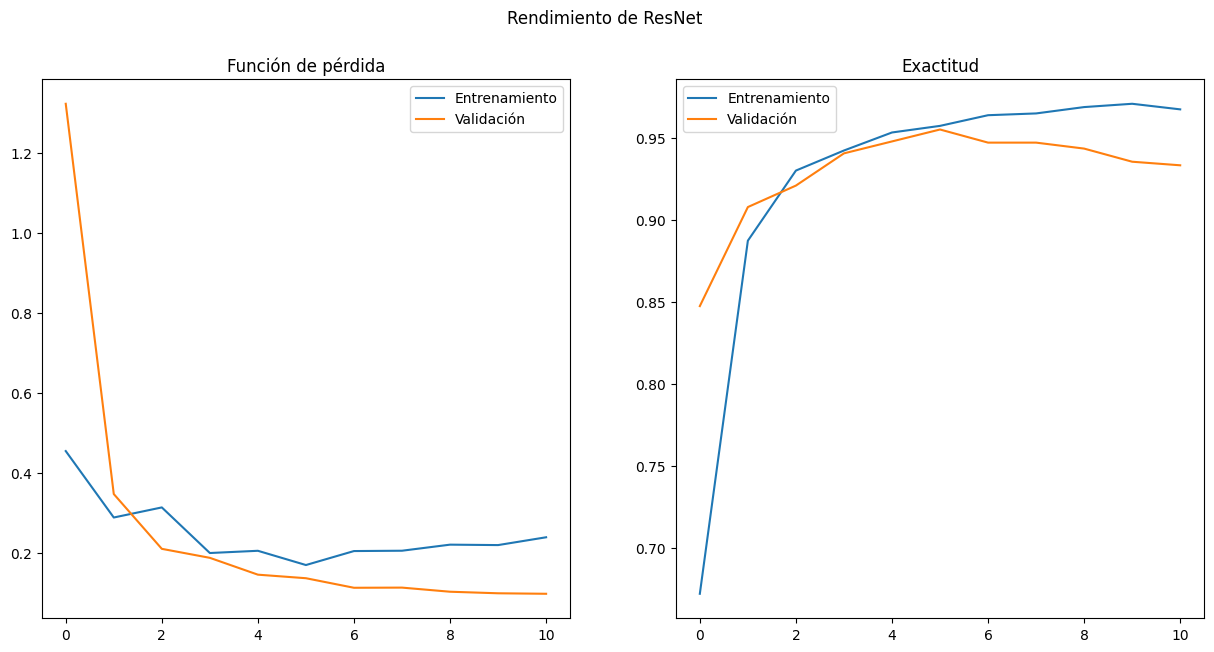

In [197]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_ResNET_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_ResNET_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_ResNET_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_ResNET_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento de ResNet');

## Inception

### Número de capas

In [198]:
print(f'{len(InceptionV3(include_top=False).layers)} layers')

311 layers


In [199]:
Inception_FT=create_model(InceptionV3, type='fine_tuning', layers_num=100)
Inception_FT.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_82 (InputLayer)       [(None, 256, 455, 3)]     0         
                                                                 
 sequential_24 (Sequential)  (None, None, None, 3)     0         
                                                                 
 resizing_23 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 dropout_43 (Dropout)        (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_18  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

In [200]:
Inception_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_Inception_FT=Inception_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback])

Epoch 1/100


2023-06-01 13:23:37.059601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/202 [==============================] - 13s 56ms/step - loss: 1.4251 - accuracy: 0.6532 - val_loss: 0.5698 - val_accuracy: 0.8183 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 11s 53ms/step - loss: 0.4335 - accuracy: 0.8572 - val_loss: 0.3825 - val_accuracy: 0.8692 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 11s 53ms/step - loss: 0.2938 - accuracy: 0.8982 - val_loss: 0.3012 - val_accuracy: 0.8953 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 11s 52ms/step - loss: 0.2242 - accuracy: 0.9231 - val_loss: 0.2944 - val_accuracy: 0.9012 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 11s 53ms/step - loss: 0.1895 - accuracy: 0.9332 - val_loss: 0.2538 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 11s 53ms/step - loss: 0.1529 - accuracy: 0.9465 - val_loss: 0.2241 - val_accuracy: 0.9288 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

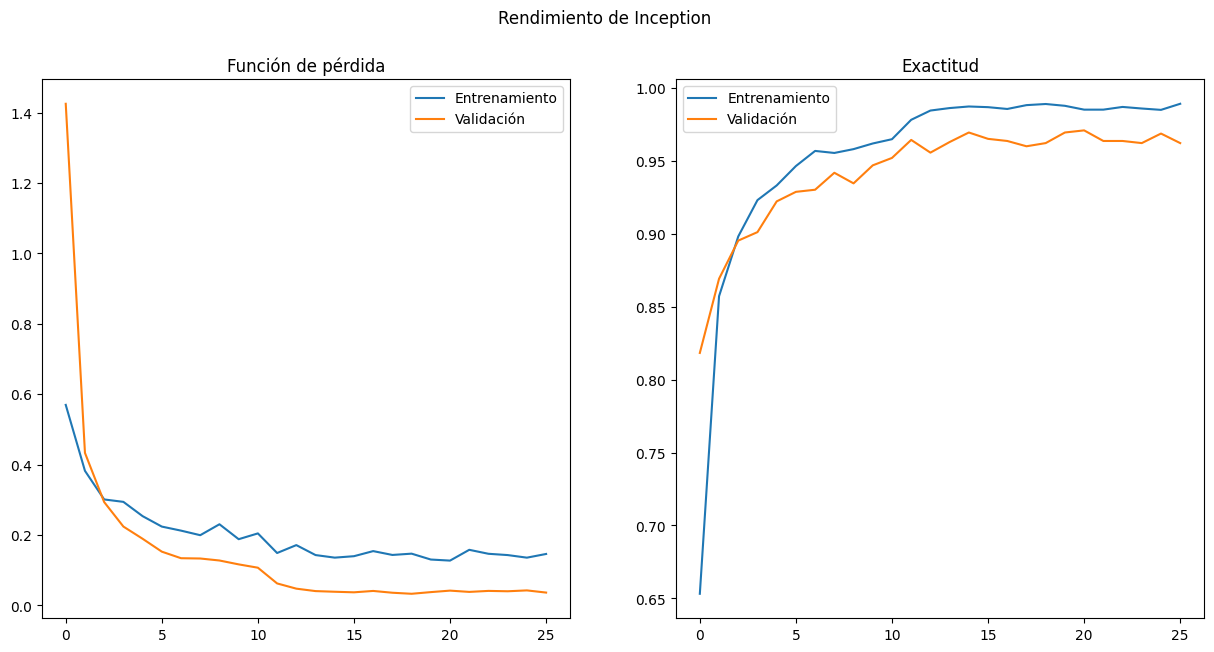

In [201]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_Inception_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_Inception_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_Inception_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_Inception_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento de Inception');

## MobileNET

### Número de capas

In [18]:
print(f'{len(MobileNet(include_top=False).layers)} layers')

86 layers


In [19]:
MobileNet_FT=create_model(model=MobileNet, type='fine_tuning', layers_num=50)
MobileNet_FT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 455, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                      

In [20]:
MobileNet_FT.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
history_MobileNet_FT=MobileNet_FT.fit(train, validation_data=dev, epochs=100, callbacks=[stop_early, lr_scheduler, tb_callback])

Epoch 1/100


2023-06-02 12:47:41.976428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-06-02 12:47:41.976593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-06-02 12:47:42.684757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-02 12:47:44.070459: I tensorflow/compiler/xla

  1/202 [..............................] - ETA: 10:02 - loss: 4.8644 - accuracy: 0.0000e+00

2023-06-02 12:47:44.847303: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-06-02 12:47:44.847328: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-06-02 12:47:44.847369: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-06-02 12:47:44.904831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


201/202 [============================>.] - ETA: 0s - loss: 1.6884 - accuracy: 0.5818

2023-06-02 12:47:51.696952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-06-02 12:47:51.697142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]


202/202 [==============================] - 13s 51ms/step - loss: 1.6837 - accuracy: 0.5826 - val_loss: 0.9995 - val_accuracy: 0.7158 - lr: 1.0000e-04
Epoch 2/100
202/202 [==============================] - 10s 50ms/step - loss: 0.6224 - accuracy: 0.8210 - val_loss: 0.5156 - val_accuracy: 0.8379 - lr: 1.0000e-04
Epoch 3/100
202/202 [==============================] - 10s 49ms/step - loss: 0.3703 - accuracy: 0.8892 - val_loss: 0.3544 - val_accuracy: 0.8859 - lr: 1.0000e-04
Epoch 4/100
202/202 [==============================] - 10s 48ms/step - loss: 0.2520 - accuracy: 0.9264 - val_loss: 0.2610 - val_accuracy: 0.9346 - lr: 1.0000e-04
Epoch 5/100
202/202 [==============================] - 10s 47ms/step - loss: 0.1837 - accuracy: 0.9519 - val_loss: 0.2298 - val_accuracy: 0.9317 - lr: 1.0000e-04
Epoch 6/100
202/202 [==============================] - 10s 49ms/step - loss: 0.1436 - accuracy: 0.9599 - val_loss: 0.1931 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 7/100
202/202 [===================

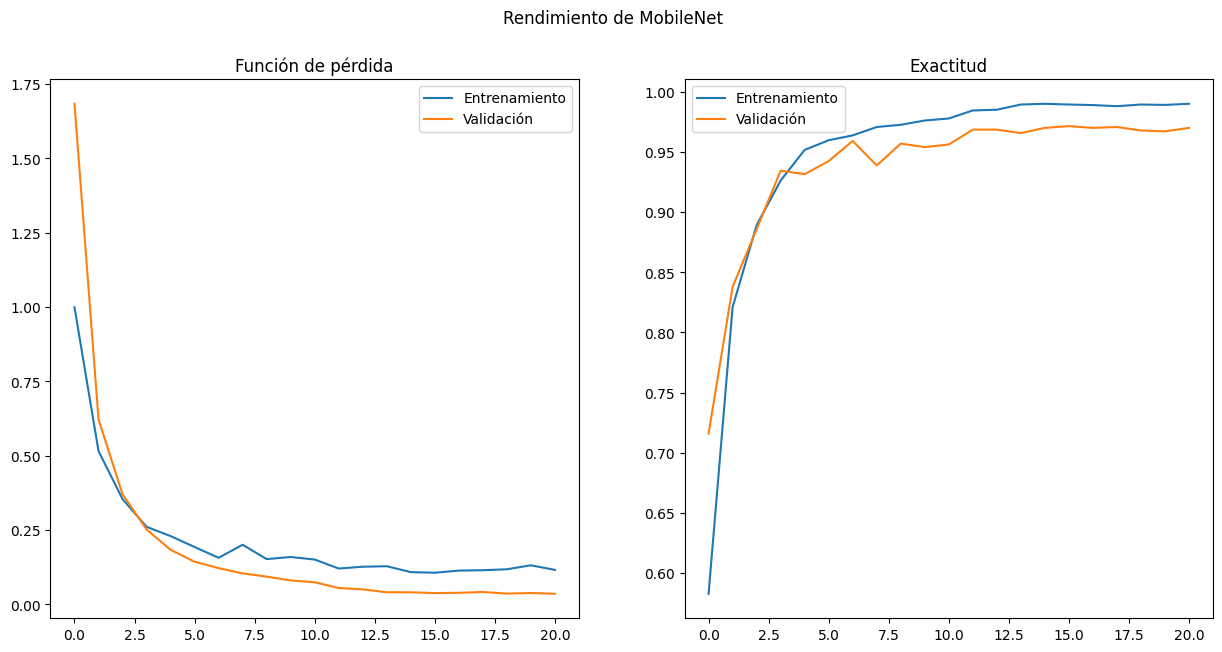

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2)
ax1.plot(history_MobileNet_FT.history['val_loss'], label='Entrenamiento')
ax1.plot(history_MobileNet_FT.history['loss'], label='Validación')
ax1.legend()
ax1.set_title('Función de pérdida')
ax2.plot(history_MobileNet_FT.history['accuracy'], label='Entrenamiento')
ax2.plot(history_MobileNet_FT.history['val_accuracy'], label='Validación')
ax2.legend()
ax2.set_title('Exactitud')
fig.set_figwidth(15)
fig.set_figheight(7)
fig.suptitle('Rendimiento de MobileNet');

# Evaluacion de modelos

In [22]:
def get_final_model(model):

    final_model=Sequential()

    final_model.add(Input(shape=(224,224,3)))
    for layer in model.layers[3:]:
        final_model.add(layer)

    final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.001))

    return final_model

In [23]:
def calculate_F1_score(test, model):
    pre=Precision()
    re=Recall()
    for batch in test.as_numpy_iterator():
        x,y=batch
        yhat=model.predict(x, verbose=0)
        pre.update_state(y, yhat)
        re.update_state(y, yhat)
    return (2*re.result()*pre.result())/(re.result()+pre.result())

In [24]:
n_data=0
for x,y in test:
    n_data+=len(x)
print(f'{n_data} datos en el set de prueba')

2023-06-02 12:51:18.477289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]
2023-06-02 12:51:18.477467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9213]
	 [[{{node Placeholder/_4}}]]


1373 datos en el set de prueba


In [209]:
print('Modelo empírico\n')
model_empirico=get_final_model(Modelo_empirico)
start=time.time()
accuracy=model_empirico.evaluate(test, verbose=0)[1]
end=time.time()
F1_Score=calculate_F1_score(test, model_empirico)
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.6f}, F1 score: {F1_Score:.6f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.6f}ms')

Modelo empírico

Tiempo de ejecución: 2.8433s, accuracy: 0.950473, F1 score: 0.952172
Tiempo de ejecución por archivo: 2.070849ms


In [210]:
print('Modelo EfficientNet\n')
model_EfficientNet=get_final_model(EfficientNET_FT)
start=time.time()
accuracy=model_EfficientNet.evaluate(test, verbose=0)[1]
end=time.time()
F1_Score=calculate_F1_score(test, model_EfficientNet)
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}, F1 score: {F1_Score:.6f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Modelo EfficientNet

Tiempo de ejecución: 4.1764s, accuracy: 0.9585, F1 score: 0.956012
Tiempo de ejecución por archivo: 3.0418ms


In [211]:
print('Modelo ResNet\n')
model_ResNet=get_final_model(ResNET_FT)
start=time.time()
accuracy=model_ResNet.evaluate(test, verbose=0)[1]
end=time.time()
F1_Score=calculate_F1_score(test, model_ResNet)
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}, F1 score: {F1_Score:.6f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Modelo ResNet

Tiempo de ejecución: 4.7506s, accuracy: 0.9476, F1 score: 0.947677
Tiempo de ejecución por archivo: 3.4600ms


In [212]:
print('Modelo Inception\n')
model_Inception=get_final_model(Inception_FT)
start=time.time()
accuracy=model_Inception.evaluate(test, verbose=0)[1]
end=time.time()
F1_Score=calculate_F1_score(test, model_Inception)
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}, F1 score: {F1_Score:.6f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Modelo Inception

Tiempo de ejecución: 3.9513s, accuracy: 0.9680, F1 score: 0.968989
Tiempo de ejecución por archivo: 2.8779ms


In [25]:
print('Modelo MobileNet\n')
model_MobileNet=get_final_model(MobileNet_FT)
start=time.time()
accuracy=model_MobileNet.evaluate(test, verbose=0)[1]
end=time.time()
F1_Score=calculate_F1_score(test, model_MobileNet)
print(f'Tiempo de ejecución: {end-start:.4f}s, accuracy: {accuracy:.4f}, F1 score: {F1_Score:.6f}')
print(f'Tiempo de ejecución por archivo: {(end-start)/n_data*1000:.4f}ms')

Modelo MobileNet

Tiempo de ejecución: 3.2450s, accuracy: 0.9687, F1 score: 0.970427
Tiempo de ejecución por archivo: 2.3635ms


In [26]:
model_MobileNet.save('models/MobileNet_trained.h5')

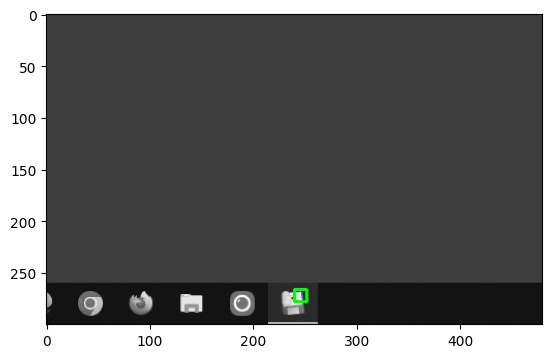

Windows_taskbar: 12.372007220983505%


In [35]:
labels=sorted(os.listdir(data_dir))
test_img=plt.imread('test1.png')
plt.imshow(test_img)
plt.show()
test_img=tf.image.resize(test_img, (224, 224))
test_img=test_img/255
pred=model_MobileNet.predict(np.expand_dims(test_img, axis=0), verbose=0)
print(f'{labels[np.argmax(pred)]}: {np.max(pred)*100}%')